# Introduction

Based on [1,2], we design an assignment for battery predictive maintenance. For more information about models and algorithms, please check out two papers below.

[1] P. Khumprom and N. Yodo, “A data-driven predictive prognostic model for lithium-ion batteries based on a deep learning algorithm,” Energies, vol. 12, no. 4, 2019.

[2] C. Wang, N. Lu, S. Wang, Y. Cheng, and B. Jiang, “Dynamic long short-term memory neural-network- based indirect remaining-useful-life prognosis for satellite Lithium-ion battery,” Appl. Sci., vol. 8, no. 11, 2018.

# Preparation Code

In [1]:
import os, datetime
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics as metrics
import seaborn as sns

In [2]:
folder = './battery1'

In [3]:
"""
Use this function to load data from .mat file (matlab format)
Parameters:
-----------
folder: path to folder that contains .mat file
battery: name of the battery that corresponds to the file name (e.g. battery B0005 corresponds to B0005.mat)
Examples:
---------
load_data('data/assignment3_battery/battery01/', 'B00005')
Returns:
dataset:
capacity: 
"""
def load_data(folder, battery):
  mat = loadmat(os.path.join(folder, battery + '.mat'))
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  #print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [4]:
dataset, capacity = load_data(folder, 'B0005')
pd.set_option('display.max_columns', 10)
print(capacity)

Total data in dataset:  616
     cycle  ambient_temperature            datetime  capacity
0        1                   24 2008-04-02 15:25:41  1.856487
1        2                   24 2008-04-02 19:43:48  1.846327
2        3                   24 2008-04-03 00:01:06  1.835349
3        4                   24 2008-04-03 04:16:37  1.835263
4        5                   24 2008-04-03 08:33:25  1.834646
..     ...                  ...                 ...       ...
163    164                   24 2008-05-26 10:44:38  1.293464
164    165                   24 2008-05-26 15:30:43  1.288003
165    166                   24 2008-05-26 20:21:04  1.287453
166    167                   24 2008-05-27 15:52:41  1.309015
167    168                   24 2008-05-27 20:45:42  1.325079

[168 rows x 4 columns]


The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle. Li-ion battery is regarded as being at End-of-Life when its capacity drops to 70% (1.38 Ah) of its initial value [2].

Text(0.5, 1.0, 'Discharge')

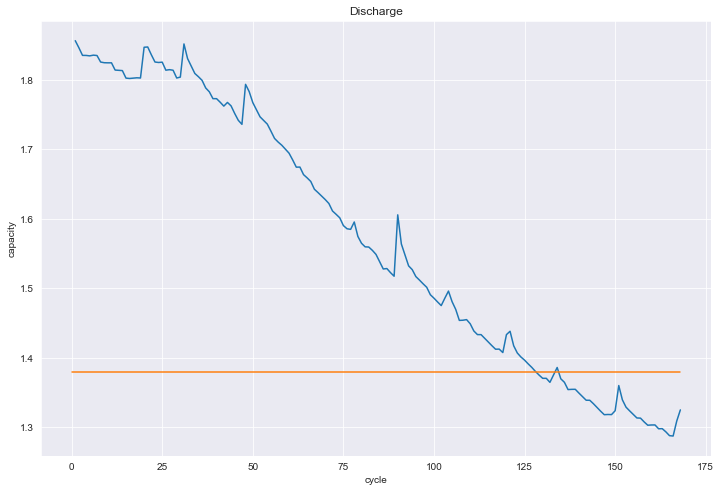

In [5]:
plot_df = capacity.loc[(capacity['cycle'] >= 1), ['cycle','capacity']]
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
plt.plot([0., len(capacity)], [1.38,1.38])
plt.ylabel('capacity')
plt.xlabel('cycle')
plt.title('Discharge')

# Problem 1: State of health (SoH) Estimation

In [6]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0] # initial capacity
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Similarly to what was done previously, a graph of the SoH is made for each cycle, the horizontal line represents the 70% threshold at which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

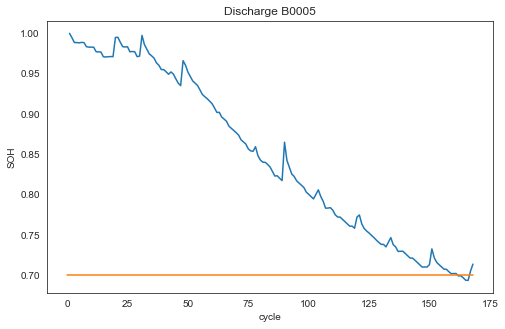

In [7]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
plt.xlabel('cycle')
plt.title('Discharge B0005')

## Training phase

The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output that is expected to be obtained. For the input data, the relevant characteristics of the dataset are filtered, which are:

Battery capacity
Voltage
Current
Temperature
Charging voltage
Charging current
Instant of time (from the start of the download)
For the output data, the SoH of the battery is calculated and in both input and output cases, the values are normalized to a range of values between [0-1].

In [8]:
C = dataset['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
soh = soh.to_numpy().ravel()
print(train_dataset.shape, soh.shape)

(50285, 7) (50285,)


### Model implementation for SoH estimation

In [10]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(train_dataset, soh)


Generation 1 - Current best internal CV score: -1.2305372562696133e-28

Generation 2 - Current best internal CV score: -9.483224659754853e-32

Generation 3 - Current best internal CV score: -3.129544047438421e-32

Generation 4 - Current best internal CV score: -3.129544047438421e-32

Generation 5 - Current best internal CV score: -3.129544047438421e-32
                                                           
Best pipeline: LassoLarsCV(FastICA(input_matrix, tol=0.55), normalize=False)


TPOTRegressor(generations=5, population_size=50, random_state=42, verbosity=2)

## Evaluate SoH prediction model

Test the model on SoH estimation of the battery B0006

In [11]:
dataset_val, capacity_val = load_data(folder, 'B0006')
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0] # initial capacity
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.008730             24.515123       -1.9990         3.045  53.781  
4         -2.013381             24.676053       -1.9990         3.026  71.922  
   cy

We create a table containing the real SoH and the predicted SoH by the model. Then, we calculate errors of results.

In [15]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
test_df = sc.fit_transform(dataset_val[attrib])

C = dataset_val['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
soh = np.array(soh)

print(tpot.score(test_df, soh))
tpot.export('tpot_soh_pipeline.py')
# soh prediction
# soh_pred = ?
# print(soh_pred.shape)

-0.006501379536768239


In [12]:
C = dataset_val['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
#print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)

NameError: name 'soh_pred' is not defined

## Plot SoH estimation results

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# 2. Remaining Useful Life (RUL) estimation

RUL is another way to estimate the failure of a battery. We use data of the first 50 cycles to predict the capacity in the following cycles. By that, we can estimate when the battery level reach the failure threshold. In other words. the failure threshold is called the End-of-Life (EOL) of a battery, which is when its capacity drops to 70% (1.38 Ah) of the initial value.

In [ ]:
dataset_val, capacity_val = load_data(folder, 'B0005')
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows = ['cycle','capacity']
dataset = dis_ele[rows]
# for simplicity, train w/ 50 cycle of B0005. You can train w/ full samples of B0005 & test w/ other batteries
data_train = dataset[(dataset['cycle'] < 50)]
data_set_train = data_train.iloc[:,1:2].values
data_test = dataset[(dataset['cycle'] >= 50)]
data_set_test = data_test.iloc[:,1:2].values

sc = MinMaxScaler(feature_range=(0,1))
data_set_train = sc.fit_transform(data_set_train)
data_set_test = sc.transform(data_set_test)

X_train = []
y_train = []
# here is the input for LSTM; If you use other algorithm, let's change the input format.
# take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train = np.array(X_train),np.array(y_train)
 
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

## Training phase
Based on [2], we can build an LSTM model for prediction.

In [ ]:
# You model code here

## Evaluate RUL estimation model

In [ ]:
len_dt_test = len(data_test)
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
# here is the input for LSTM; If you use other algorithm, let's change the input format correspondingly.
for i in range(10,len_dt_test+10):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred=reg_model.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
mae = mean_absolute_error(tests, pred)
print('Test RMSE: %.3f' % rmse)
print('Test RMSE: %.3f' % mae)

## Visual predicted results

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
# Draw threshold
plt.plot([0.,len(capacity)], [1.38, 1.38],dashes=[6, 2], label="threshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

In [ ]:
a = data_test['capacity'].values
b = data_test['pre'].values
Afil, Pfil = -1,-1
j,k = 0,0
for i, actual in enumerate(a):
    if actual <= 1.38:
        Afil = i
        break

for i, pred in enumerate(b):
    if pred < 1.38:
        Pfil = i
        break

if Pfil != -1 and Afil !=-1:
    print("The Actual fail at cycle number: %i" % (Afil+ln))
    print("The prediction fail at cycle number: %i" % (Pfil+ln))
    RULerror = Pfil - Afil
    print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")
else:
    print("Model may be underfitting")

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__(LSTM)
        self.layer1 = nn.LSTM(params)
    
    def forward(self, x):
        return self.layer1(x)

